In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import bbknn

import os
import joblib

In [2]:
sc.settings.verbosity = 0            # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map = 'RdPu', figsize = (5, 5))

scanpy==1.7.1 anndata==0.7.5 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [3]:
# Choose min_dist, spread
min_dist = 0.2 # default = 0.5
spread = 1 #default = 1

## Read in all data

In [4]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/RNA_adult-8reg_raw_rmdblcls_celltype-annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 629041 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence'
    var: 'gene_name_scRNA-0', 'gene_name_snRNA-1', 'gene_name_multiome-2'
    uns: 'cell_or_nuclei_colors', 'cell_state_HCAv1_colors', 'cell_state_scNym_colors', 'cell_type_colors', 'donor_colors', 'kit_10x_colors', 'leiden_scVI_colors', 'region_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous', 'latent_gene_encoding'
    obsp: 'connectivities', 'distances'

In [5]:
adata.var.head(1)

gene_name_scRNA-0 gene_name_snRNA-1 gene_name_multiome-2
ENSG00000243485       MIR1302-2HG       MIR1302-2HG          MIR1302-2HG

In [6]:
adata.obs.head(1)

sangerID combinedID donor donor_type  \
barcode                                                                         
HCAHeart7606896_GATGAGGCACGGCTAC  HCAHeart7606896         na    D1        DBD   

                                 region region_finest    age  gender facility  \
barcode                                                                         
HCAHeart7606896_GATGAGGCACGGCTAC     AX            AX  50-55  Female   Sanger   

                                 cell_or_nuclei  ... scrublet_leiden  \
barcode                                          ...                   
HCAHeart7606896_GATGAGGCACGGCTAC           Cell  ...             2,0   

                                 cluster_scrublet_score doublet_pval  \
barcode                                                                
HCAHeart7606896_GATGAGGCACGGCTAC               0.184933     0.084434   

                                  doublet_bh_pval          batch_key  \
barcode                                                                
HCAHeart7606896_GATGAGGCACGGCTAC          0.83272  D1_Cell_3prime-v2   

                                  leiden_scVI         cell_type  \
barcode                                                           
HCAHeart7606896_GATGAGGCACGGCTAC           21  Endothelial cell   

                                  cell_state_HCAv1  cell_state_scNym  \
barcode                                                                
HCAHeart7606896_GATGAGGCACGGCTAC           EC5_art               nan   

                                  cell_state_scNym_confidence  
barcode                                                        
HCAHeart7606896_GATGAGGCACGGCTAC                          NaN  

[1 rows x 31 columns]

In [7]:
# replace the var_names with gene name, for both adata.var and adata.raw.var
# adata.raw.var['gene_id']=adata.raw.var_names
# adata.raw.var.set_index(genename_column, inplace=True)
genename_column='gene_name_multiome-2'

adata.var['gene_id']=adata.var_names
adata.var.set_index(genename_column, inplace=True)
adata.var_names=adata.var_names.astype('str')
adata.var_names_make_unique()

In [8]:
print(adata.shape)
adata = adata[adata.obs['region'].isin(['AVN'])]
print(adata.shape)
adata = adata[adata.obs['cell_type'].isin(['Atrial Cardiomyocyte','Ventricular Cardiomyocyte'])]
print(adata.shape)

(629041, 32732)
(21037, 32732)
(11264, 32732)


Trying to set attribute `.var` of view, copying.


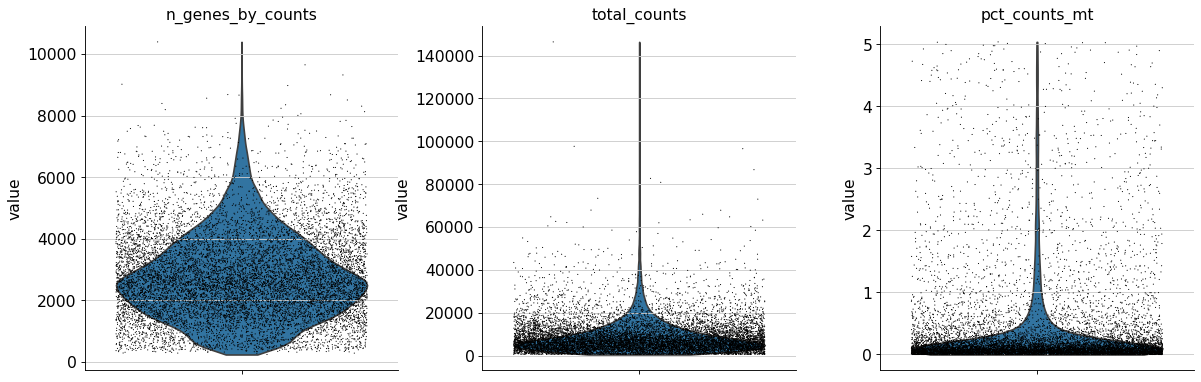

In [9]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [10]:
# Since we are starting with raw object, need to perform basic QC steps
sc.pp.filter_genes(adata, min_cells=3)

In [11]:
# normalise and logtransform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # save raw count data

In [12]:
%%time

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#sc.pl.highly_variable_genes(adata)

# freeze the state in `.raw`
adata.raw = adata

# subset hvgs
adata = adata[:, adata.var.highly_variable]

CPU times: user 1.11 s, sys: 156 ms, total: 1.27 s
Wall time: 1.27 s


In [13]:
%%time
# regress out - not needed if using scVI object
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

CPU times: user 11min 26s, sys: 13min 25s, total: 24min 51s
Wall time: 2min 30s


In [14]:
sc.pp.scale(adata, max_value=10)

In [15]:
sc.tl.pca(adata, svd_solver='arpack')

## Deciding resolution

In [16]:
%%time
sc.pp.neighbors(adata)
sc.tl.umap(adata, min_dist=min_dist, spread=spread, n_components=3)

CPU times: user 24.5 s, sys: 7.82 s, total: 32.3 s
Wall time: 21.5 s


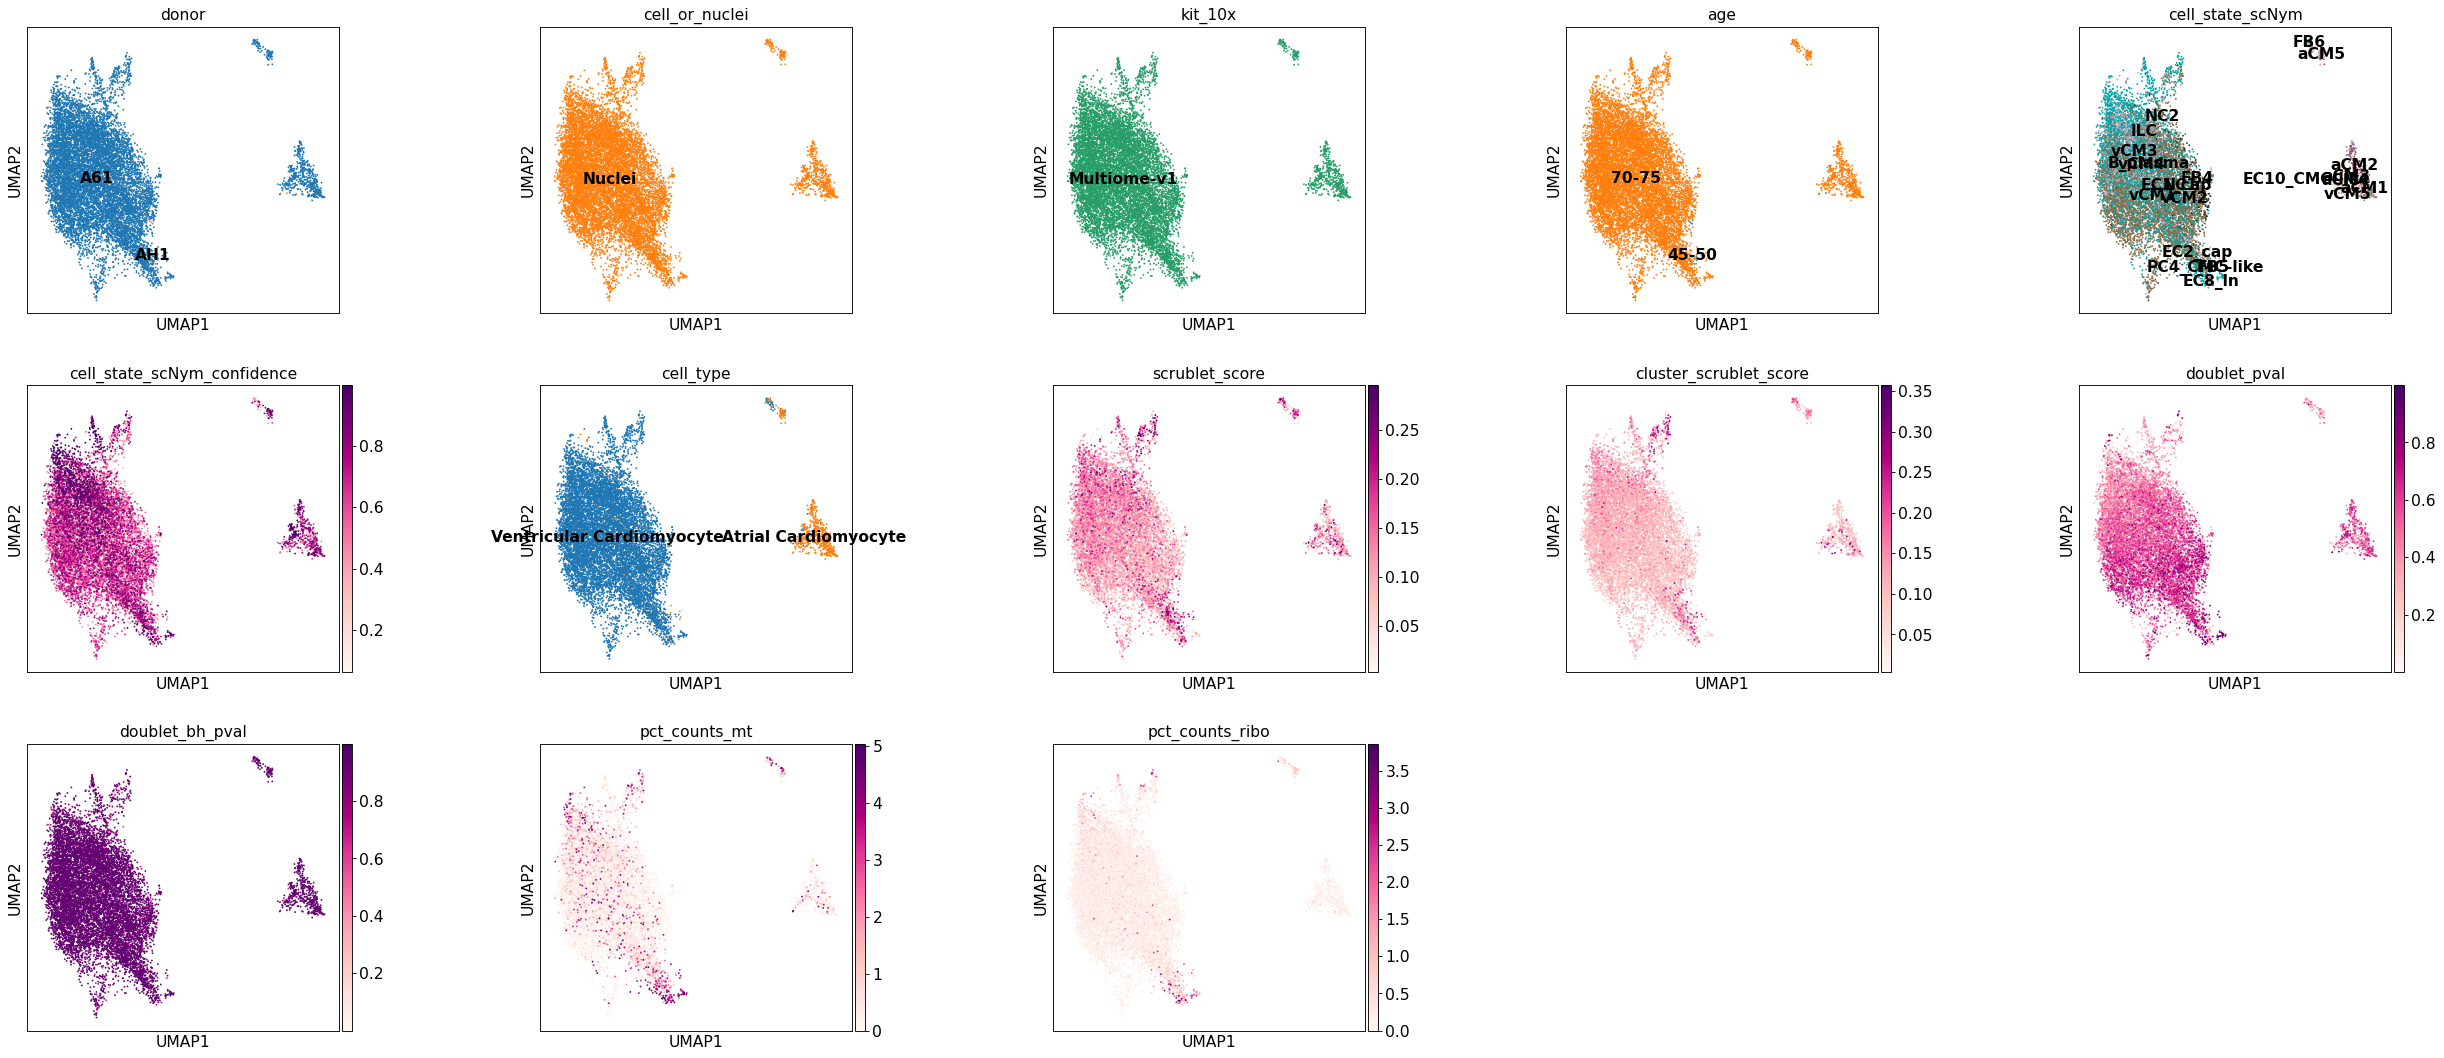

In [17]:
sc.pl.umap(adata, color=['donor','cell_or_nuclei','kit_10x','age','cell_state_scNym','cell_state_scNym_confidence','cell_type','scrublet_score','cluster_scrublet_score','doublet_pval','doublet_bh_pval','pct_counts_mt','pct_counts_ribo'],wspace=0.5,ncols=5,legend_loc='on data')

In [18]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color=['TNNI1','S100A4','HAMP','PLA2G2A','NES','GJA1','GJA5','GJC1','GPX3','IGFBP6','PRELP','TIMP3','MYL4','MYL7','SCN5A','IRX2','CACNA1D','HCN1','HCN4','NPPA','SHOX2','TBX2','TBX3','TBX5','NKX2-5','MEIS1','NFIA','HAND1','PITX2','SOX5','TBX20','CRNDE','IRX3','IRX5','SLN','MYH6','PAM','COMP','MYBPHL','SLIT3','ACTA2'],
#           components='all',
           wspace=0.5, ncols=3)

In [19]:
resolutions = [
    0.1,
#    0.2,
#    0.3,
#    0.4,
#    0.5,
#    0.6,
#    0.7,
#    0.8,
#    0.9,
#    1.0,
#    1.2,
#    1.5,
#    2.0,
#    3.0,
#    4.0
]

leiden_0.1


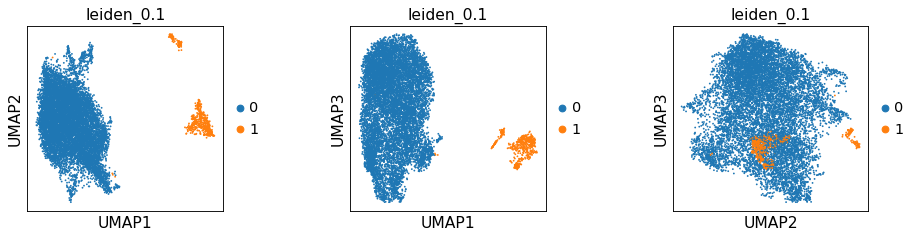

CPU times: user 988 ms, sys: 0 ns, total: 988 ms
Wall time: 987 ms


In [20]:
%%time
#plot multiple resolutions
for res in resolutions:
    print(str(f'leiden_{res}'))
    sc.tl.leiden(adata, resolution=res, key_added=f'leiden_{res}')
    sc.pl.umap(adata, color=[f'leiden_{res}'], components='all', wspace=0.5)

# Choose a resolution

In [21]:
leiden_resolution = 0.1
chosen_res = f'leiden_{leiden_resolution}'

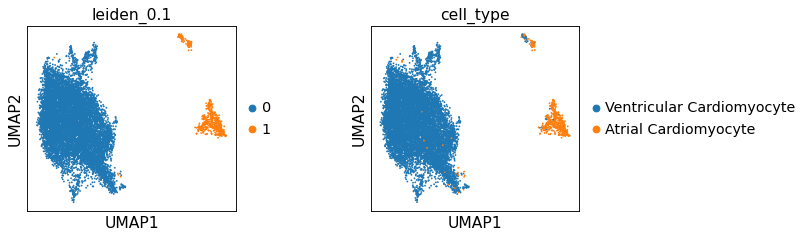

In [22]:
sc.pl.umap(adata, color=[chosen_res,'cell_type'],
#           groups='9',
           wspace=0.5,
#           components ='all'
          )

In [23]:
# Split into 1 vs 0, then sucluster 1

print(adata.shape)
clus1 = adata[adata.obs[chosen_res]=='1']
adata = clus1
print(adata.shape)

(11264, 3277)
(573, 3277)


In [24]:
print(adata.shape)
adata = adata.raw.to_adata() # recover log-normed data to .X layer
print(adata.shape)

(573, 3277)
(573, 25597)


In [25]:
%%time

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#sc.pl.highly_variable_genes(adata)

# freeze the state in `.raw`
adata.raw = adata

# subset hvgs
adata = adata[:, adata.var.highly_variable]

CPU times: user 530 ms, sys: 17.8 ms, total: 548 ms
Wall time: 547 ms


In [26]:
%%time
# regress out - not needed if using scVI object
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

CPU times: user 15.7 s, sys: 0 ns, total: 15.7 s
Wall time: 15.7 s


In [27]:
sc.pp.scale(adata, max_value=10)

In [28]:
sc.tl.pca(adata, svd_solver='arpack')

## Deciding resolution

In [29]:
%%time
sc.pp.neighbors(adata)
sc.tl.umap(adata, min_dist=min_dist, spread=spread, n_components=3)

CPU times: user 2.81 s, sys: 1.49 s, total: 4.3 s
Wall time: 1.81 s


In [30]:
sc.pl.umap(adata, color=['donor','cell_or_nuclei','kit_10x','age','cell_state_scNym','cell_state_scNym_confidence','cell_type','scrublet_score','cluster_scrublet_score','doublet_pval','doublet_bh_pval','pct_counts_mt','pct_counts_ribo'],wspace=0.5,ncols=5,legend_loc='on data')

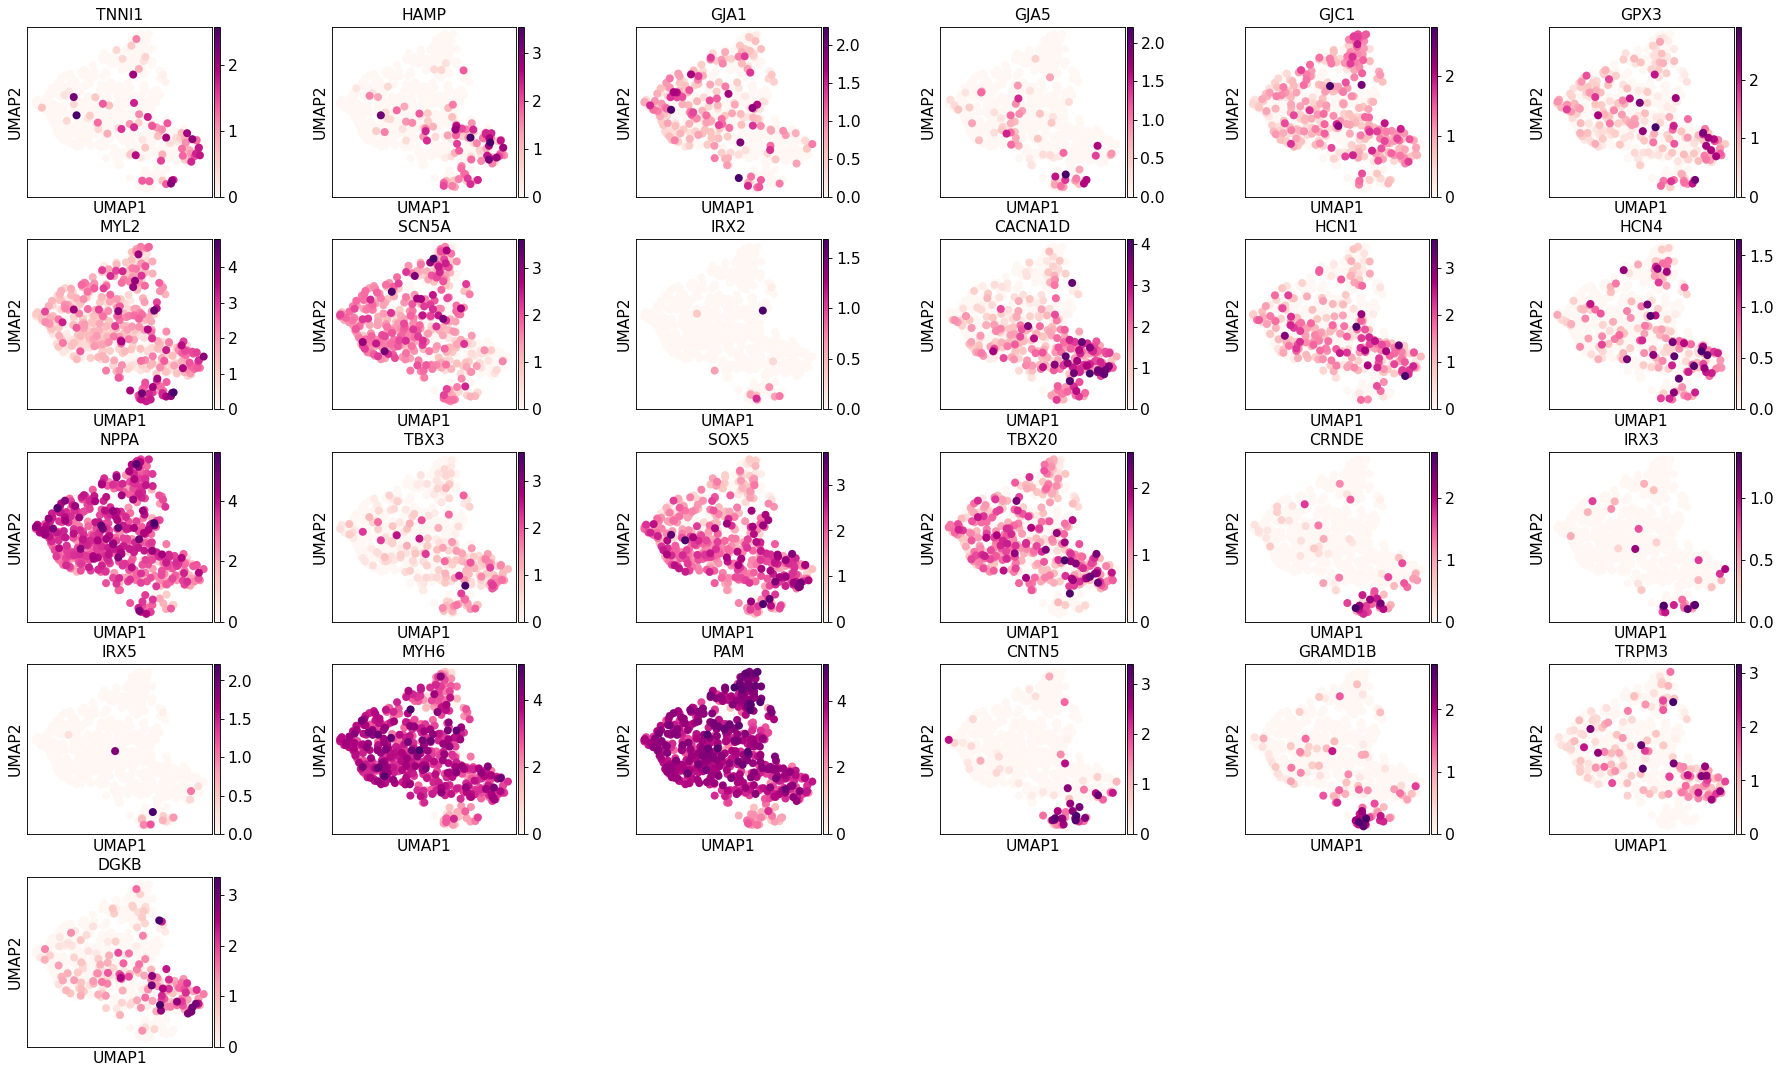

In [31]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color=['TNNI1','HAMP','GJA1','GJA5','GJC1','GPX3','MYL2','SCN5A','IRX2','CACNA1D','HCN1','HCN4','NPPA','TBX3','SOX5','TBX20','CRNDE','IRX3','IRX5','MYH6','PAM','CNTN5','GRAMD1B','TRPM3','DGKB'],
#           components='all',
           wspace=0.5, ncols=6)

In [32]:
resolutions = [
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    1.0,
#    1.2,
#    1.5,
#    2.0,
#    3.0,
#    4.0
]

leiden_0.1


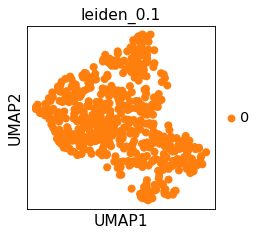

leiden_0.2


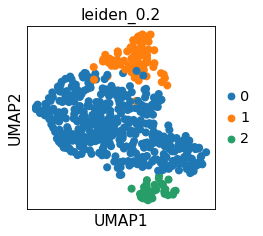

leiden_0.3


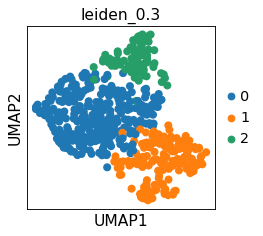

leiden_0.4


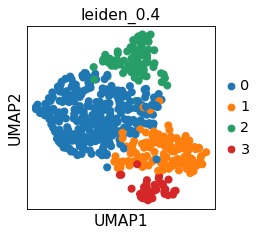

leiden_0.5


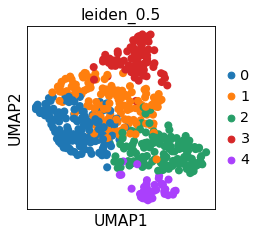

leiden_0.6


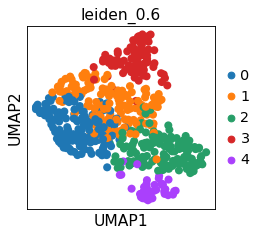

leiden_0.7


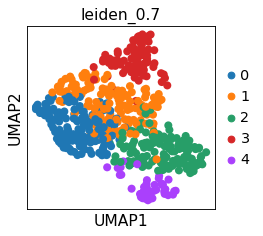

leiden_0.8


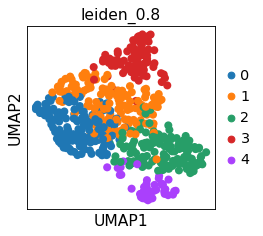

leiden_0.9


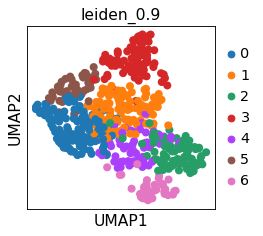

leiden_1.0


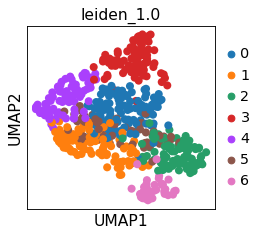

CPU times: user 2.19 s, sys: 33.8 ms, total: 2.22 s
Wall time: 2.21 s


In [33]:
%%time
#plot multiple resolutions
for res in resolutions:
    print(str(f'leiden_{res}'))
    sc.tl.leiden(adata, resolution=res, key_added=f'leiden_{res}')
    sc.pl.umap(adata, color=[f'leiden_{res}'],
#               components='all',
               wspace=0.5)

# Choose a resolution

In [34]:
leiden_resolution = 0.9
chosen_res = f'leiden_{leiden_resolution}'

In [35]:
sc.pl.umap(adata, color=chosen_res,
#           groups='9',
           wspace=0.5, components ='all')

In [36]:
adata.var_names=adata.var_names.astype('str')
adata.var_names_make_unique()

# Look for doublets

In [37]:
# proportion of scrublet score > 0.2 per cluster
df=pd.crosstab(adata.obs['scrublet_score']>0.2,adata.obs[chosen_res]).T.copy()
df=df.apply(lambda x:x[True]/np.sum(x), axis=1)
df=df.sort_values(ascending=False)
df=pd.DataFrame(df).rename(columns={0:'prop of scrubscore>0.2'})
df

prop of scrubscore>0.2
leiden_0.9                        
6                         0.166667
1                         0.112150
5                         0.090909
2                         0.085106
3                         0.056180
0                         0.051095
4                         0.050000

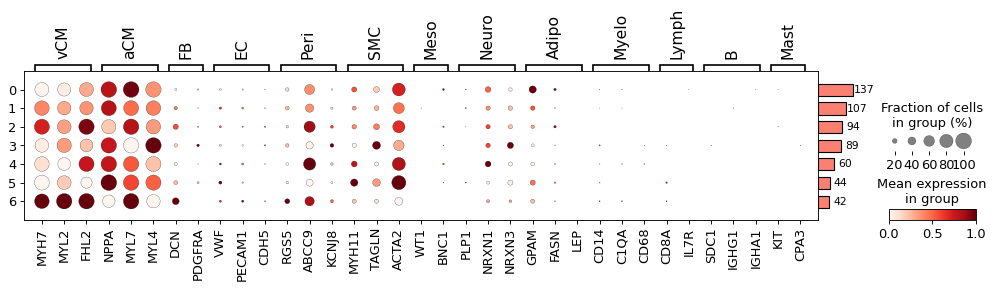

In [38]:
# Checking global markers
markers = {
    'vCM': ['MYH7', 'MYL2', 'FHL2'],
    'aCM': ['NPPA', 'MYL7', 'MYL4'],
    'FB': ['DCN', 'GCN', 'PDGFRA'],
    'EC': ['VWF', 'PECAM1', 'CDH5'],
    'Peri': ['RGS5', 'ABCC9', 'KCNJ8'],
    'SMC': ['MYH11', 'TAGLN', 'ACTA2'],
    'Meso': ['MSLN', 'WT1', 'BNC1'],
    'Neuro': ['PLP1', 'NRXN1', 'NRXN3'],
    'Adipo': ['GPAM', 'FASN', 'LEP'],
    'Myelo': ['CD14', 'C1QA', 'CD68'],
    'Lymph': ['CD8A', 'IL7R', 'CD40LG'],
    'B': ['CD19','SDC1','IGHG1','IGHA1'],
    'Mast': ['KIT', 'CPA3'],
}

for key in markers.keys():
    markers[key]=[x for x in markers[key] if x in adata.raw.var_names]

dp=sc.pl.dotplot(adata,
              markers, 
              groupby=chosen_res,
              dendrogram=False,
              standard_scale="var",
              color_map="Reds",
              return_fig=True,
                 use_raw=True
              # swap_axes=True,
             )
dp.add_totals().show()

# Marker expression

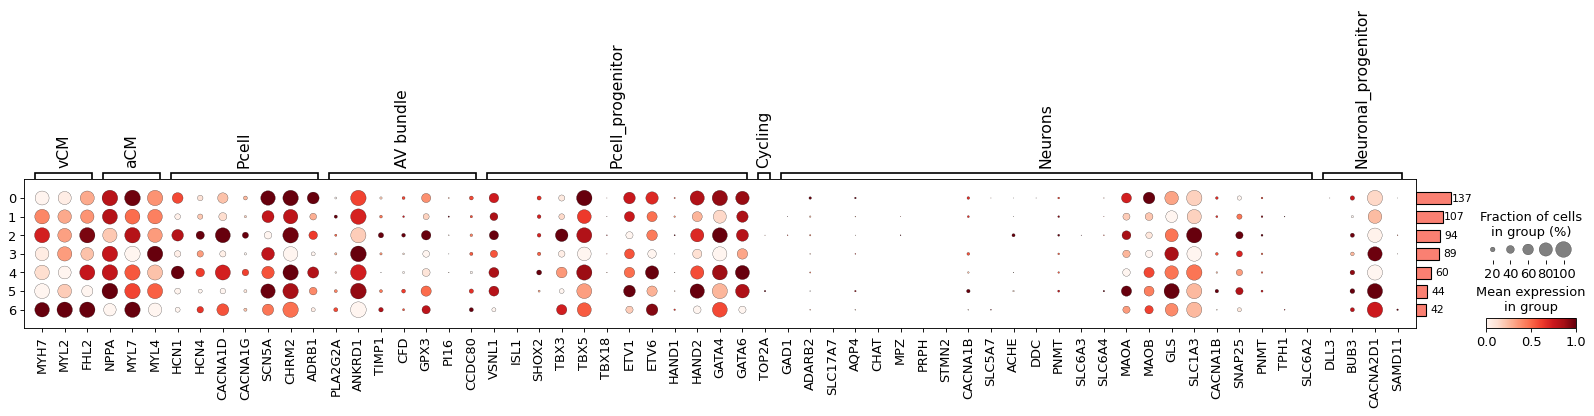

In [39]:
# Checking conduction system markers
markers={
    'vCM': ['MYH7', 'MYL2', 'FHL2'],
    'aCM': ['NPPA', 'MYL7', 'MYL4'],
    'Pcell': ['HCN1','HCN4','CACNA1D','CACNA1G','SCN5A','CHRM2','ADRB1'],
    'AV bundle': ['PLA2G2A','ANKRD1','TIMP1','CFD','GPX3','PI16','CCDC80'],
    'Pcell_progenitor': ['VSNL1','ISL1','SHOX2','TBX3','TBX5','TBX18','ETV1','ETV6','HAND1','HAND2', 'GATA4', 'GATA6'],
    'Cycling':['MKI67','TOP2A'],
    'Neurons': ['GAD1','ADARB2','SLC17A7','VIP','AQP4','SST','GAL','NPY','CHAT','TH','MPZ','PRPH','STMN2','CACNA1B','SLC5A7','SLC18A3','ACHE',
                         'TH','DBH','DDC','PNMT',
                         'SST','GAL','VIP','TAC1',
                         'SLC6A3','SLC6A4','MAOA','MAOB',
                         'GLS','GLS1','SLC1A3','CACNA1B', 'SNAP25','PNMT','TPH1','SLC6A2'],
    'Neuronal_progenitor': ['ASCL1', 'DLL3', 'BUB3', 'CACNA2D1', 'FNCD5', 'SAMD11']
}

for key in markers.keys():
    markers[key]=[x for x in markers[key] if x in adata.raw.var_names]

dp = sc.pl.dotplot(adata,
              markers, 
              groupby=chosen_res,
              dendrogram=False,
              standard_scale="var",
              color_map="Reds",
              return_fig = True,
#                   use_raw=True
              # swap_axes=True,
             )
dp.add_totals().show()

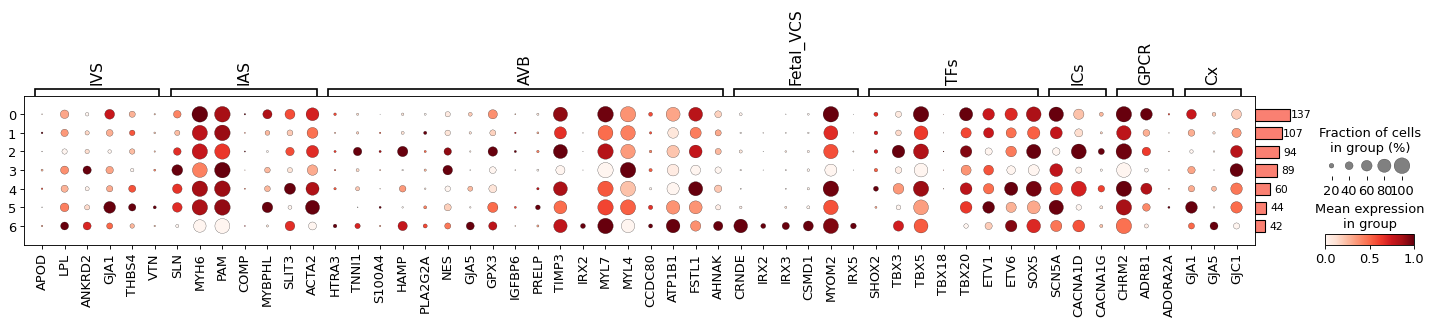

In [40]:
# Checking conduction system markers
markers={
    'IVS': ['APOD','LPL','ANKRD2','GJA1','THBS4','VTN'],
    'IAS':['SLN','MYH6','PAM','COMP','MYBPHL','SLIT3','ACTA2'],
    'AVB': ['HTRA3','TNNI1','S100A4','HAMP','PLA2G2A','NES','GJA5','GPX3','IGFBP6','PRELP','TIMP3','IRX2','MYL7','MYL4','CCDC80','ATP1B1','FSTL1','AHNAK'],
    'Fetal_VCS':['CRNDE','IRX2','IRX3','CSMD1','MYOM2','IRX5'],
    'TFs': ['SHOX2','TBX3','TBX5','TBX18','TBX20','ETV1','ETV6','SOX5'],
    'ICs':['SCN5A','CACNA1D','CACNA1G'],
    'GPCR':['CHRM2','ADRB1','ADORA2A'],
    'Cx':['GJA1','GJA5','GJC1','GJD3']
}

for key in markers.keys():
    markers[key]=[x for x in markers[key] if x in adata.raw.var_names]

dp = sc.pl.dotplot(adata,
              markers, 
              groupby=chosen_res,
              dendrogram=False,
              standard_scale="var",
              color_map="Reds",
              return_fig = True,
#                   use_raw=True
              # swap_axes=True,
             )
dp.add_totals().show()

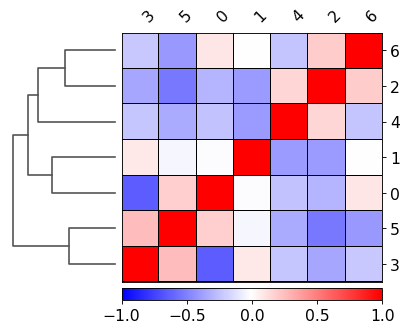

In [46]:
ax = sc.pl.correlation_matrix(adata, chosen_res)

# Find contributionsto each cluster

[]

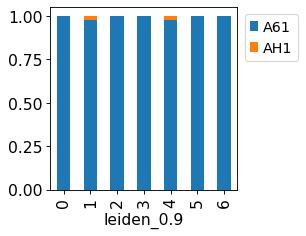

In [47]:
tmp = pd.crosstab(adata.obs[chosen_res],adata.obs['donor'], normalize='index')
# tmp.plot.bar().legend(loc=1)
ax = tmp.plot.bar(stacked=True)
ax.grid(False)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

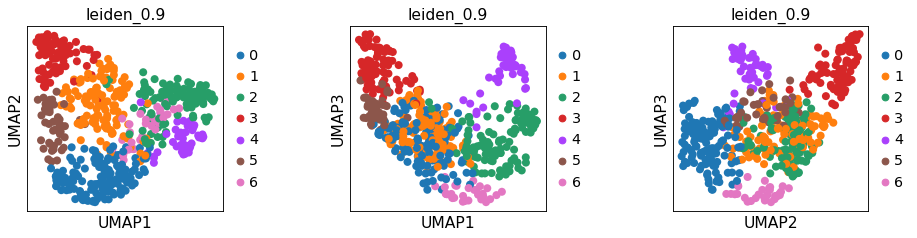

In [48]:
sc.pl.umap(adata, color=chosen_res,
#           groups='9',
           wspace=0.5, components ='all')

In [49]:
sc.tl.rank_genes_groups(adata,groupby=chosen_res,method='wilcoxon')

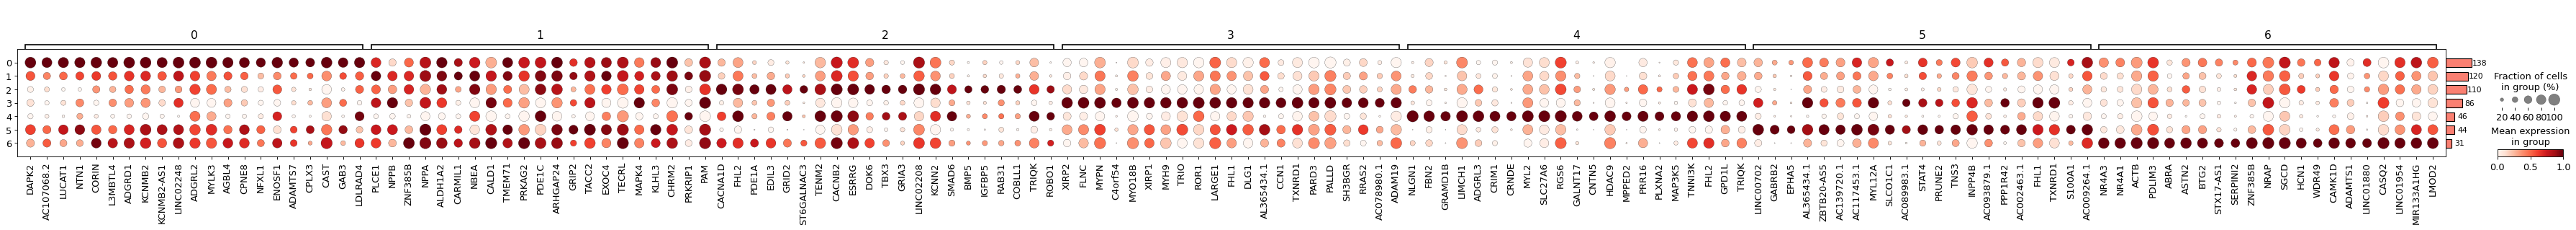

In [50]:
dp = sc.pl.rank_genes_groups_dotplot(adata,
                                groupby=chosen_res,
                                standard_scale='var',
                               return_fig=True,
                                    n_genes = 21,
                                    dendrogram = False)

dp.add_totals().show()

In [41]:
adata.obs['heart_regions'] = adata.obs[str(chosen_res)].astype(str)
adata.obs.replace({'heart_regions':{
    '0':'aCM',
    '1':'aCM',
    '2':'P_cell',
    '3':'aCM',
    '4':'unknown', 
    '5':'aCM', 
    '6':'VCS', 
#    '7':'valve', 
#    '8':'coronary', 
#    '9':'trabeculated',
#    '10':'compact',
#    '11':'epi'
}}, inplace=True)

adata.obs['heart_regions']=adata.obs['heart_regions'].astype('category')
adata.obs['heart_regions'].value_counts()

aCM        377
P_cell      94
unknown     60
VCS         42
Name: heart_regions, dtype: int64

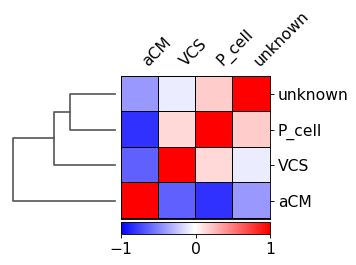

In [42]:
ax = sc.pl.correlation_matrix(adata, 'heart_regions')

In [43]:
sc.tl.rank_genes_groups(adata,groupby='heart_regions',method='wilcoxon')

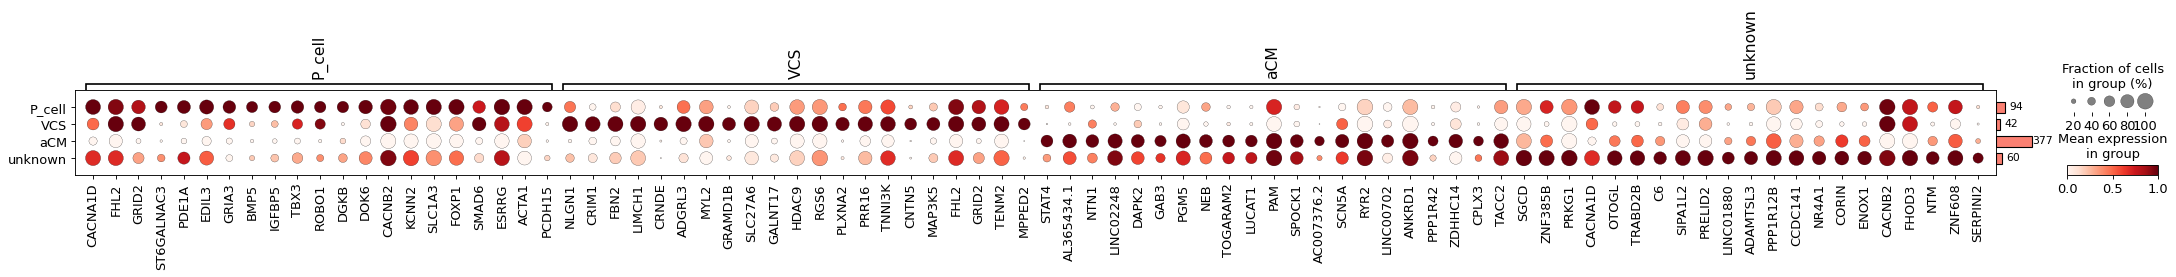

In [44]:
dp = sc.pl.rank_genes_groups_dotplot(adata,
                                groupby='heart_regions',
                                standard_scale='var',
                               return_fig=True,
                                    n_genes = 21,
                                    dendrogram = False)

dp.add_totals().show()

In [45]:
chosen_group = 'P_cell'
reference = 'VCS'

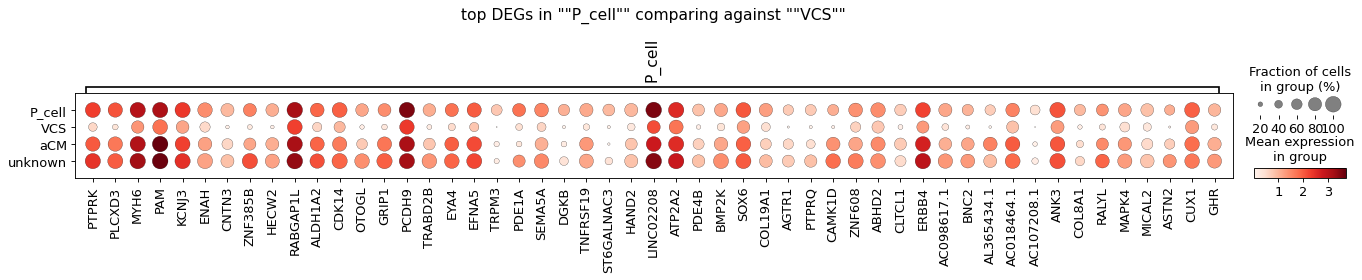

In [46]:
sc.tl.rank_genes_groups(adata,groupby='heart_regions',
                        groups = [chosen_group],
                        reference = reference,
                        method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata,groupby='heart_regions',groups=[chosen_group],n_genes=51,
#                                standard_scale='var',
                                title = 'top DEGs in ""'+str(chosen_group)+'"" comparing against ""'+str(reference)+'"''"',
                                dendrogram = False
                               )

In [47]:
adata.obs['cell_state'] = adata.obs['heart_regions'].astype(str)
adata.obs.replace({'cell_state':{
    'P_cell':'AVN_P_cell',
    'VCS':'AVN_bundle_cell',
    'unknown':'AVN_P_cell',
    'aCM':'aCM',
#    '4':'unknown', 
#    '5':'aCM', 
#    '6':'VCS', 
#    '7':'valve', 
#    '8':'coronary', 
#    '9':'trabeculated',
#    '10':'compact',
#    '11':'epi'
}}, inplace=True)

adata.obs['cell_state']=adata.obs['cell_state'].astype('category')
adata.obs['cell_state'].value_counts()

aCM                377
AVN_P_cell         154
AVN_bundle_cell     42
Name: cell_state, dtype: int64

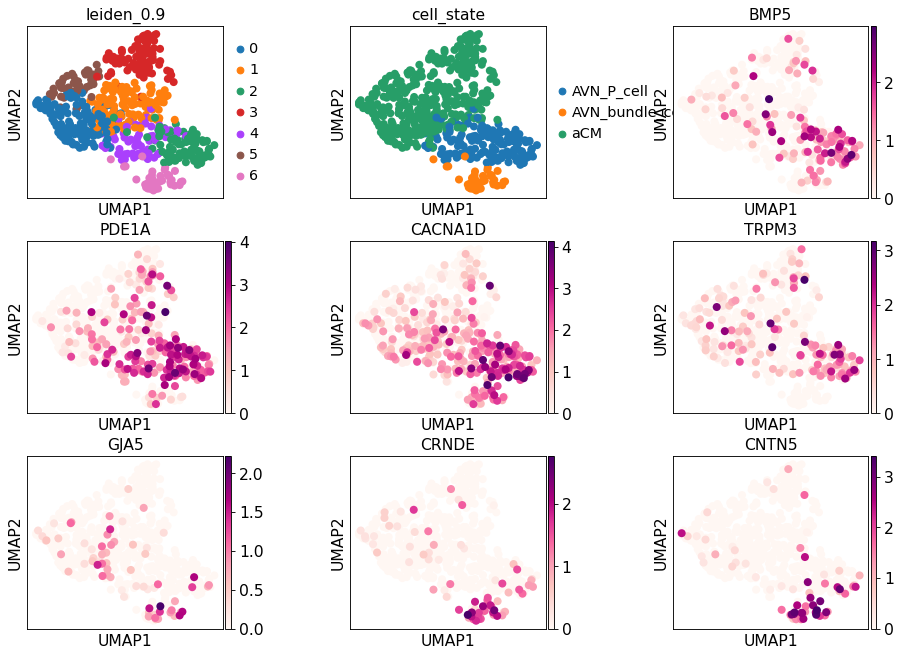

In [48]:
sc.pl.umap(adata, color=[chosen_res,'cell_state','BMP5','PDE1A','CACNA1D','TRPM3','GJA5','CRNDE','CNTN5'],
#           groups='9',
           wspace=0.5,
#           components ='all',
           ncols = 3
          )

In [ ]:
sc.tl.rank_genes_groups(adata,groupby='cell_state',method='wilcoxon')

In [ ]:
dp = sc.pl.rank_genes_groups_dotplot(adata,
                                groupby='cell_state',
                                standard_scale='var',
                               return_fig=True,
                                    n_genes = 21,
                                    dendrogram = False)

dp.add_totals().show()

In [ ]:
chosen_group = 'AVN_bundle_cell'
reference = 'AVN_P_cell'

In [ ]:
sc.tl.rank_genes_groups(adata,groupby='cell_state',
                        groups = [chosen_group],
                        reference = reference,
                        method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata,groupby='cell_state',groups=[chosen_group],n_genes=51,
#                                standard_scale='var',
                                title = 'top DEGs in ""'+str(chosen_group)+'"" comparing against ""'+str(reference)+'"''"',
                                dendrogram = False
                               )

# Export indexes to main object

In [53]:
# Combine objects to form final annotation

AVN_P_cell = adata.obs.index[adata.obs['cell_state'] == 'AVN_P_cell']
AVN_P_cell = AVN_P_cell.to_frame()
AVN_P_cell.to_csv('/home/jovyan/notebooks/suspension/scanpy_clustering/indexes/AVN_P_cell.csv', index = False, header=True)


AVN_bundle_cell = adata.obs.index[adata.obs['cell_state'] == 'AVN_bundle_cell']
AVN_bundle_cell = AVN_bundle_cell.to_frame()
AVN_bundle_cell.to_csv('/home/jovyan/notebooks/suspension/scanpy_clustering/indexes/AVN_bundle_cell.csv', index = False, header=True)




In [75]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/RNA_adult-8reg_raw_rmdblcls_celltype-annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 629041 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence'
    var: 'gene_name_scRNA-0', 'gene_name_snRNA-1', 'gene_name_multiome-2'
    uns: 'cell_or_nuclei_colors', 'cell_state_HCAv1_colors', 'cell_state_scNym_colors', 'cell_type_colors', 'donor_colors', 'kit_10x_colors', 'leiden_scVI_colors', 'region_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous', 'latent_gene_encoding'
    obsp: 'connectivities', 'distances'

In [76]:
# replace the var_names with gene name, for both adata.var and adata.raw.var
# adata.raw.var['gene_id']=adata.raw.var_names
# adata.raw.var.set_index(genename_column, inplace=True)
genename_column='gene_name_multiome-2'

adata.var['gene_id']=adata.var_names
adata.var.set_index(genename_column, inplace=True)
adata.var_names=adata.var_names.astype('str')
adata.var_names_make_unique()

In [77]:
print(adata.shape)
adata = adata[adata.obs['region'].isin(['AVN'])]
print(adata.shape)
adata = adata[adata.obs['cell_type'].isin(['Atrial Cardiomyocyte','Ventricular Cardiomyocyte'])]
print(adata.shape)

(629041, 32732)
(21037, 32732)
(11264, 32732)


In [78]:
AVN_P_cell = pd.read_csv('/home/jovyan/notebooks/suspension/scanpy_clustering/indexes/AVN_P_cell.csv')
AVN_P_cell = AVN_P_cell['barcode']

AVN_bundle_cell = pd.read_csv('/home/jovyan/notebooks/suspension/scanpy_clustering/indexes/AVN_bundle_cell.csv')
AVN_bundle_cell = AVN_bundle_cell['barcode']


adata.obs['cell_state'] = adata.obs['cell_type'].copy()
adata.obs['cell_state'] = adata.obs['cell_state'].astype(str)

adata.obs.loc[AVN_P_cell, 'cell_state'] = 'AVN_P_cell'
adata.obs.loc[AVN_bundle_cell, 'cell_state'] = 'AVN_bundle_cell'

Trying to set attribute `.obs` of view, copying.


In [79]:
# Since we are starting with raw object, need to perform basic QC steps
sc.pp.filter_genes(adata, min_cells=3)

In [80]:
# normalise and logtransform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # save raw count data

In [81]:
%%time

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#sc.pl.highly_variable_genes(adata)

# freeze the state in `.raw`
adata.raw = adata

# subset hvgs
adata = adata[:, adata.var.highly_variable]

CPU times: user 1.23 s, sys: 266 ms, total: 1.5 s
Wall time: 1.5 s


In [82]:
%%time
# regress out - not needed if using scVI object
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'cell_state' as categorical


CPU times: user 11min 5s, sys: 13min 22s, total: 24min 27s
Wall time: 2min 27s


In [83]:
sc.pp.scale(adata, max_value=10)

In [84]:
sc.tl.pca(adata, svd_solver='arpack')

In [85]:
%%time
sc.pp.neighbors(adata)
sc.tl.umap(adata, min_dist=min_dist, spread=spread, n_components=3)

CPU times: user 10.8 s, sys: 7.63 s, total: 18.4 s
Wall time: 6.84 s


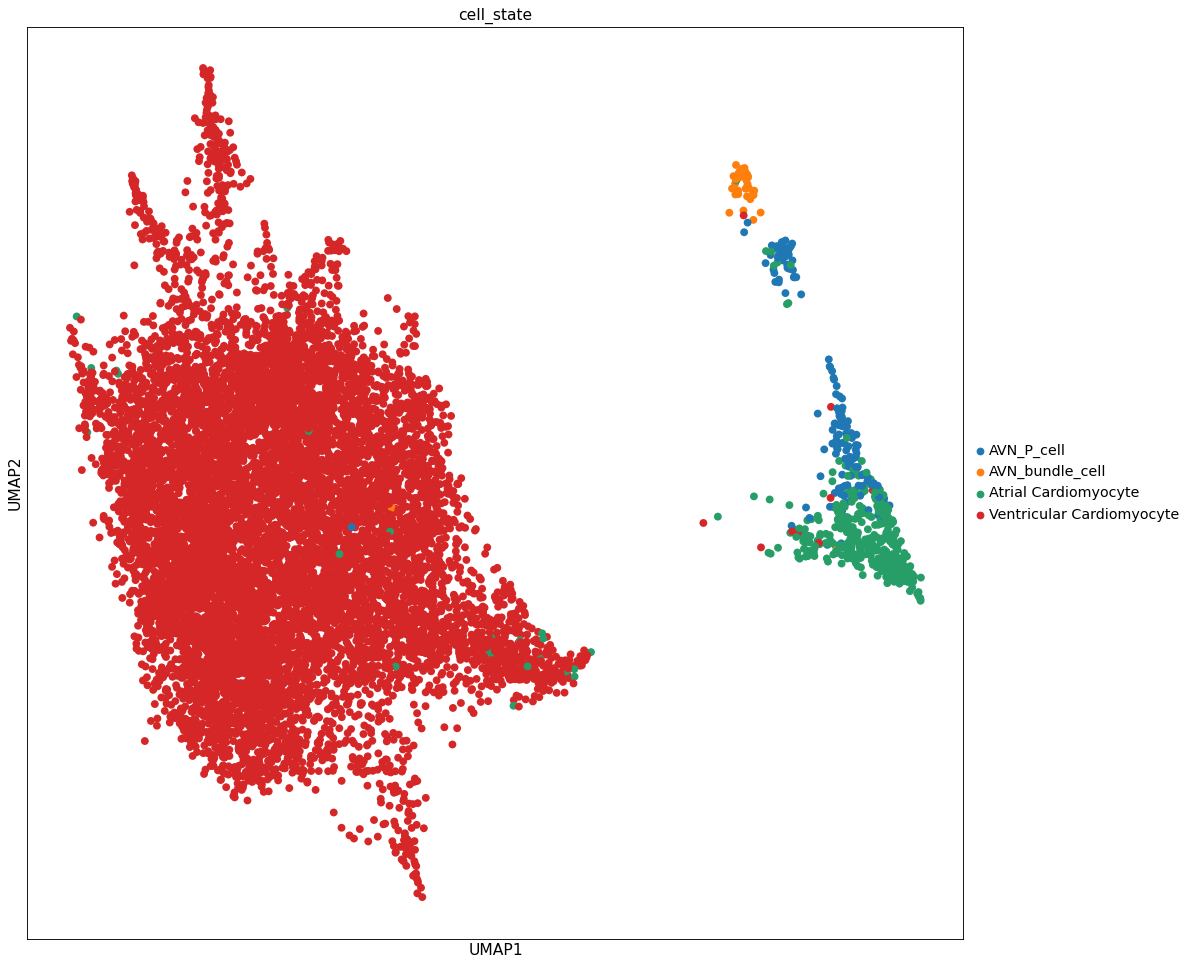

In [86]:
plt.rcParams["figure.figsize"] = (15, 15)
sc.pl.umap(adata,color = 'cell_state', size = 200)

In [87]:
sc.tl.rank_genes_groups(adata,groupby='cell_state',method='wilcoxon')

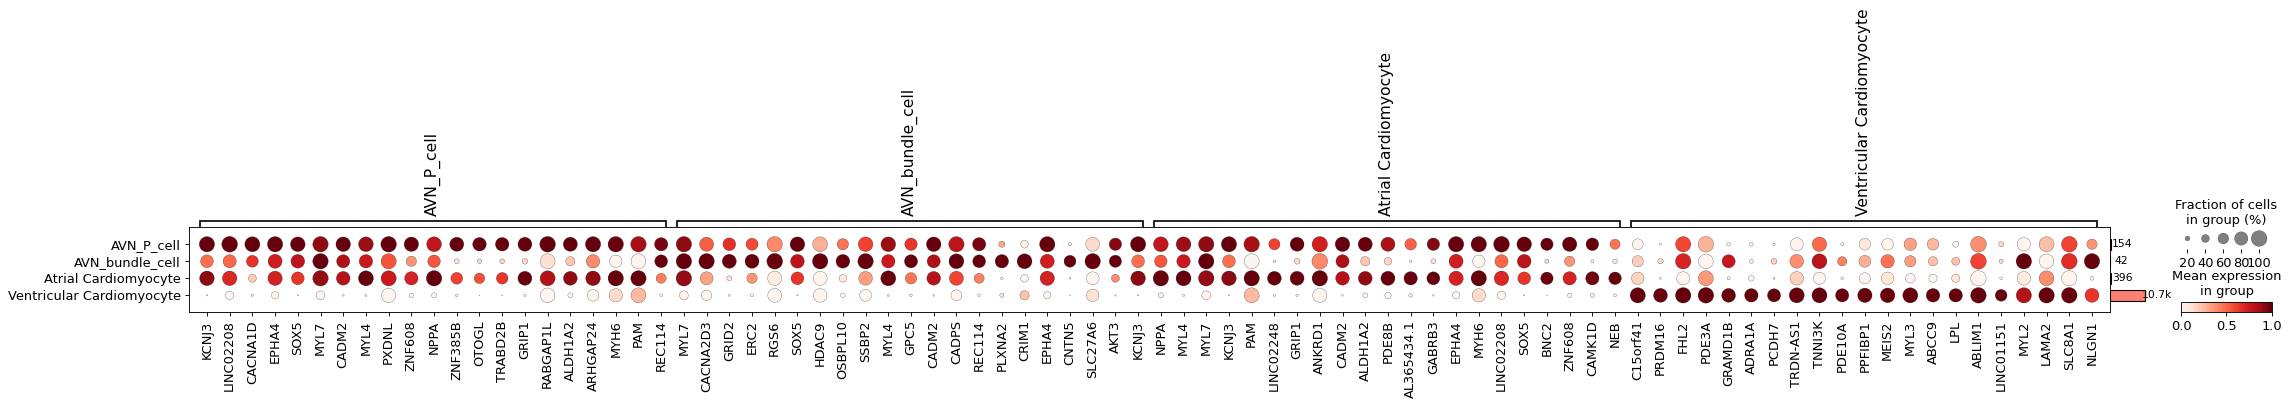

In [88]:
dp = sc.pl.rank_genes_groups_dotplot(adata,
                                groupby='cell_state',
                                standard_scale='var',
                               return_fig=True,
                                    n_genes = 21,
                                    dendrogram = False)

dp.add_totals().show()

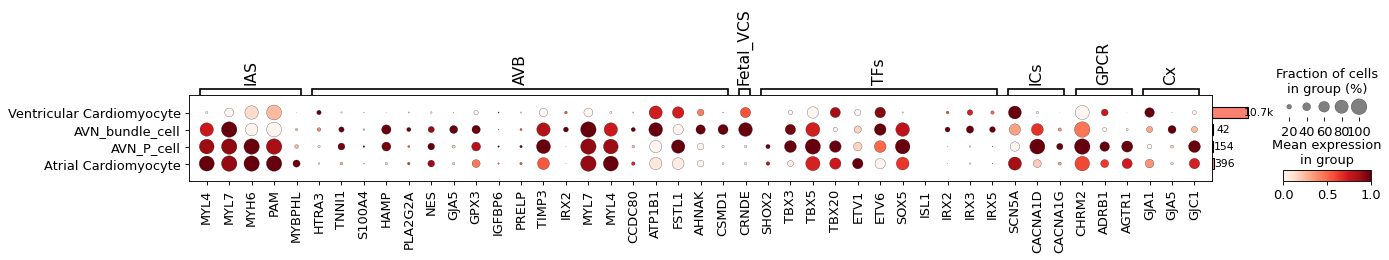

In [95]:
# Checking conduction system markers
markers={
    'IAS':['MYl2','MYL4','MYL7','MYH6','PAM','MYBPHL'],
    'AVB': ['HTRA3','TNNI1','S100A4','HAMP','PLA2G2A','NES','GJA5','GPX3','IGFBP6','PRELP','TIMP3','IRX2','MYL7','MYL4','CCDC80','ATP1B1','FSTL1','AHNAK','CSMD1'],
    'Fetal_VCS':['CRNDE'],
    'TFs': ['SHOX2','TBX3','TBX5','TBX20','ETV1','ETV6','SOX5','ISL1','IRX2','IRX3','IRX5'],
    'ICs':['SCN5A','CACNA1D','CACNA1G'],
    'GPCR':['CHRM2','ADRB1','AGTR1'],
    'Cx':['GJA1','GJA5','GJC1']
}

for key in markers.keys():
    markers[key]=[x for x in markers[key] if x in adata.raw.var_names]

dp = sc.pl.dotplot(adata,
              markers, 
              groupby='cell_state',
              dendrogram=True,
              standard_scale="var",
              color_map="Reds",
              return_fig = True,
#                   use_raw=True
              # swap_axes=True,
             )
dp.add_totals().show()

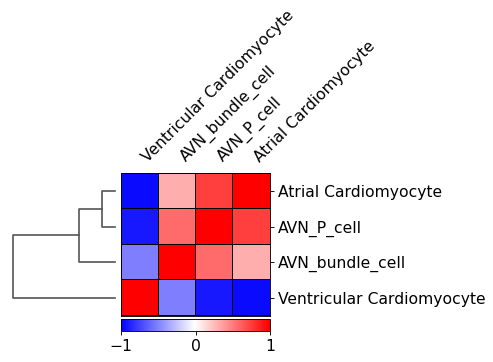

In [92]:
ax = sc.pl.correlation_matrix(adata, 'cell_state')

In [96]:
tmp = pd.crosstab(adata.obs['cell_state'],adata.obs['donor'], normalize='index')
# tmp.plot.bar().legend(loc=1)
ax = tmp.plot.bar(stacked=True)
ax.grid(False)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

[]

In [91]:
#save the data
adata.write('/nfs/team205/heart/JC_annotated_adata/AVN_v4.h5ad')